<a href="https://colab.research.google.com/github/Ak705945/DR-detection-using-DCNN/blob/main/Copy_of_MiniProject4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import tensorflow_datasets as tfds
from keras.models import Sequential,Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation,BatchNormalization,concatenate,Input
from keras import losses
from keras.optimizers import Adam, Adagrad,SGD
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import model_from_json
from sklearn.model_selection import GridSearchCV
import keras
from keras.preprocessing import image
from keras.layers import LeakyReLU
import os
from google.colab import files

In [ ]:
import zipfile      #this block loads the data and extracts it in colab's storage
local_zip = '/content/drive/My Drive/Data/Copy of gaussian_filtered_images.zip'    # enter the dataset's zip folder location
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')    #enter destination location

zip_ref.close()

In [ ]:
train_path='/content/gaussian_filtered_images'      # location of the training dataset


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3      #model with the use of transfer learning on InceptionV3
from keras.regularizers import l1_l2,l1,l2

input_tensor = Input(shape=(224, 224, 3))

base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)    # added inceptionV3 architecture

# add a global spatial average pooling layer
x = base_model.output
x=Flatten()(x)
x = Dropout(0.4)(x)
final_output = Dense(5, activation='softmax', name='final_output')(x)
model = Model(inputs=input_tensor, outputs=final_output)


model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(beta_1=0.9,beta_2=0.999,epsilon=1e-08,learning_rate=0.0001), metrics=["accuracy"])
model.summary()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator         # image datagen for preparing training and test set using image data augmentation

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2,rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory( train_path,      #creating train data generator and test data genarator

    target_size=(224,224),
    batch_size=32
    ,shuffle=True,class_mode='categorical',
    subset='training',

)
validation_generator = train_datagen.flow_from_directory( train_path,
     #   '../input/test_resizedvgg net/',
        target_size=(224,224),
        batch_size=32,
        shuffle=True,
        class_mode='categorical',
    subset='validation'
        )

Found 2931 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
# model.compile(loss=keras.losses.categorical_crossentropy, optimizer=SGD(lr=0.001), metrics=["accuracy"])
from collections import Counter
counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class CustomCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs={}):
            if(logs['accuracy']>0.8 and logs['val_accuracy']>0.78):
                print("\n Desired acc reached")
                model.stop_training = True

modelhist = model.fit(
        train_generator,
        epochs=25,
        validation_data=validation_generator,
        class_weight=class_weights,
        callbacks=[CustomCallback()]
        )

Epoch 1/25
92/92 [==============================] - 56s 613ms/step - loss: 3.6917 - accuracy: 0.4995 - val_loss: 3.2436 - val_accuracy: 0.5075
Epoch 2/25
92/92 [==============================] - 55s 600ms/step - loss: 2.9640 - accuracy: 0.5899 - val_loss: 1.1422 - val_accuracy: 0.6347
Epoch 3/25
92/92 [==============================] - 55s 593ms/step - loss: 2.6520 - accuracy: 0.6462 - val_loss: 0.8078 - val_accuracy: 0.6443
Epoch 4/25
92/92 [==============================] - 54s 592ms/step - loss: 2.5449 - accuracy: 0.6557 - val_loss: 0.7098 - val_accuracy: 0.7114
Epoch 5/25
92/92 [==============================] - 54s 590ms/step - loss: 2.3926 - accuracy: 0.6957 - val_loss: 1.1100 - val_accuracy: 0.5540
Epoch 6/25
92/92 [==============================] - 56s 614ms/step - loss: 2.2655 - accuracy: 0.7001 - val_loss: 0.8612 - val_accuracy: 0.6430
Epoch 7/25
92/92 [==============================] - 56s 610ms/step - loss: 2.1615 - accuracy: 0.7233 - val_loss: 0.6759 - val_accuracy: 0.7059

In [ ]:
model_name = 'Test-79.4 Train-82.1.h5'     #this block is to save the trained model
save_dir = '/content/Model' #directory where to save the model
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/Model/Test-79.4 Train-82.1.h5 


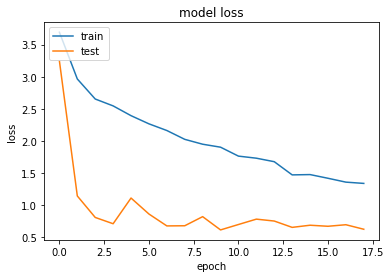

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelhist.history['loss'])
plt.plot(modelhist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("km_loss.png")
plt.close()

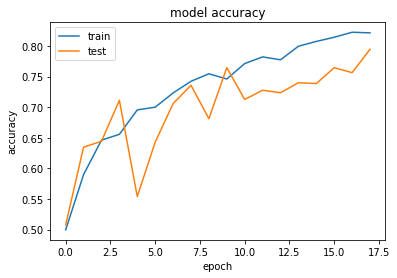

In [ ]:
import matplotlib.pyplot as plt
plt.plot(modelhist.history['accuracy'])
plt.plot(modelhist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("km_accuracy.png")
plt.close()

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Model/Test-79.4 Train-82.1.h5')   # to load a pretrained model
loaded_model.summary()

In [ ]:
loaded_model.evaluate_generator(validation_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.591740071773529, 0.807113528251648]

In [ ]:
uploaded=files.upload()     # this block load's an image and classify it using loaded model
for fn in uploaded.keys():
  path = fn
  img=image.load_img(path,target_size=(224,224))
  x=image.img_to_array(img)
  x=np.expand_dims(x,axis=0)
  images=np.vstack([x])
  classes=loaded_model.predict(images,batch_size=10)
  print(fn)
  print(classes)

In [ ]:
import numpy as np
import cv2

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def GaussianBlur_PreProcess(img, sigmaX):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

In [ ]:

for level in os.listdir(test_path):   #apply the gaussian blur to each image in the data set
  for my_image in os.listdir(test_path + "/" + level):
    im = cv2.imread(test_path + "/" + level + '/' + my_image)
    res = GaussianBlur_PreProcess(im, 33)
    path = '/content/prepros_data/TRAIN_Resizedvgg net/' + level + '/'
    os.makedirs(path,exist_ok =True)
    # cv2.imwrite('/content/prepros_data/TRAIN_Resizedvgg net/' + level + '/' + my_image, res)
    cv2.imwrite(os.path.join(path , my_image), res)

In [ ]:
from zipfile import ZipFile
import os
from os.path import basename      #make a zip file for images after applying gaussian blur
# create a ZipFile object
for level in os.listdir('/content/prepros_data/TRAIN_Resizedvgg net'):
  with ZipFile(level+'.zip', 'w') as zipObj:
    # Iterate over all the files in directory
    for folderName, subfolders, filenames in os.walk('/content/prepros_data/TRAIN_Resizedvgg net/'+level):
        for filename in filenames:
            #create complete filepath of file in directory
            filePath = os.path.join(folderName, filename)
            # Add file to zip
            zipObj.write(filePath, basename(filePath))